🧩 Cell 1 – Import & Config dasar

In [1]:
# Cell 1: Import libraries dan konfigurasi dasar

import os
import re
import numpy as np
import pandas as pd

from pathlib import Path

# Untuk split data dan evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Untuk deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# Seed biar hasil lebih konsisten (optional)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Path folder torso per frame (SUSAIKAN DENGAN PUNYAMU)
FOLDER_TORSO = r"E:\1.Clustering_TA\3output_clustering\02_torso_per_frame"

# Mapping subject → label
SUBJECT_TO_LABEL = {
    "Afi": 0,
    "Kinan": 1,
    "Miftah": 2,
}

# Konfigurasi model / dataset
FEATURE_NAMES = [
    "torso_x",
    "torso_y",
    "torso_z",
    "vx",
    "vy",
    "vz",
    "is_held_from_prev",
    "t_norm",
]

PAD_VALUE_AFTER_NORM = -10.0  # nilai padding setelah normalisasi (supaya kalah di max-pool)

print("Config OK.")


Config OK.


🧩 Cell 2 – Helper parsing nama file & baca satu trial

In [2]:
# Cell 2: Helper untuk parsing nama file & membaca satu trial

def parse_subject_trial_from_filename(fname: str):
    """
    Contoh nama file:
    Afi_Jalan10_clustered_torso.csv
    Kinan_Jalan72_clustered_torso.csv
    
    Return:
        subject (str), trial_name (str), trial_num (int)
    """
    stem = Path(fname).stem  # Afi_Jalan10_clustered_torso
    # Pecah dengan underscore
    parts = stem.split("_")  # ["Afi", "Jalan10", "clustered", "torso"] (kurang lebih)
    if len(parts) < 2:
        raise ValueError(f"Format nama file tidak dikenali: {fname}")
    
    subject = parts[0]
    trial_raw = parts[1]  # contoh "Jalan10"

    # Ambil angka di belakang "Jalan" untuk trial_num
    m = re.search(r"(\d+)", trial_raw)
    if m:
        trial_num = int(m.group(1))
    else:
        trial_num = -1  # fallback, kalau tidak ada angka
    
    trial_name = trial_raw  # simpan apa adanya
    
    return subject, trial_name, trial_num


def load_torso_csv(filepath: str):
    """
    Baca CSV torso per frame dan sort berdasarkan frame.
    Pastikan kolom yang dibutuhkan ada.
    """
    df = pd.read_csv(filepath)
    
    required_cols = [
        "frame",
        "torso_cluster_id",
        "torso_x",
        "torso_y",
        "torso_z",
        "num_points_torso",
        "is_held_from_prev",
    ]
    for col in required_cols:
        if col not in df.columns:
            raise KeyError(f"Kolom '{col}' tidak ditemukan di {filepath}")
    
    df = df.sort_values("frame").reset_index(drop=True)
    return df


print("Helper parsing & loader siap.")


Helper parsing & loader siap.


🧩 Cell 3 – Feature engineering per trial (x,y,z,vx,vy,vz,is_held,t_norm)

In [3]:
def compute_frame_features_from_torso_df(df: pd.DataFrame) -> np.ndarray:
    """
    Input: df torso per frame (sudah sorted by frame)
    Output: matrix fitur (N_frame × len(FEATURE_NAMES))

    Fitur:
      - torso_x, torso_y, torso_z
      - vx, vy, vz  (Δpos per frame)
      - is_held_from_prev
      - t_norm

    Semua NaN/inf dibersihkan → tidak boleh ada non-finite di output.
    """
    if len(df) == 0:
        return np.zeros((0, len(FEATURE_NAMES)), dtype=np.float32)

    df = df.copy()

    # 1) Bersihkan posisi: ffill → bfill → kalau masih NaN jadi 0
    for col in ["torso_x", "torso_y", "torso_z"]:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()
            df[col] = df[col].astype(float).fillna(0.0)

    # 2) Bersihkan is_held_from_prev
    if "is_held_from_prev" in df.columns:
        df["is_held_from_prev"] = df["is_held_from_prev"].fillna(0).astype(float)
    else:
        df["is_held_from_prev"] = 0.0

    # 3) Ambil posisi
    x = df["torso_x"].to_numpy(dtype=np.float32)
    y = df["torso_y"].to_numpy(dtype=np.float32)
    z = df["torso_z"].to_numpy(dtype=np.float32)

    # 4) Velocity aproksimasi
    vx = np.diff(x, prepend=x[0]).astype(np.float32)
    vy = np.diff(y, prepend=y[0]).astype(np.float32)
    vz = np.diff(z, prepend=z[0]).astype(np.float32)

    # 5) is_held_from_prev
    is_held = df["is_held_from_prev"].to_numpy(dtype=np.float32)

    # 6) t_norm 0..1
    N = len(df)
    if N > 1:
        t_norm = np.linspace(0.0, 1.0, N, dtype=np.float32)
    else:
        t_norm = np.array([0.0], dtype=np.float32)

    # 7) susun sesuai FEATURE_NAMES
    features_list = []
    for name in FEATURE_NAMES:
        if name == "torso_x":
            features_list.append(x)
        elif name == "torso_y":
            features_list.append(y)
        elif name == "torso_z":
            features_list.append(z)
        elif name == "vx":
            features_list.append(vx)
        elif name == "vy":
            features_list.append(vy)
        elif name == "vz":
            features_list.append(vz)
        elif name == "is_held_from_prev":
            features_list.append(is_held)
        elif name == "t_norm":
            features_list.append(t_norm)
        else:
            raise KeyError(f"FEATURE_NAMES berisi nama yang tidak dikenali: {name}")

    mat = np.stack(features_list, axis=1).astype(np.float32)

    # 8) LAST DEFENSE: semua non-finite → 0
    mat = np.where(np.isfinite(mat), mat, 0.0).astype(np.float32)

    return mat


🧩 Cell 4 – Kumpulkan semua trial (X_list & metadata)

In [4]:
# Cell 4: Load semua file torso, bangun list matrix fitur + metadata

all_trial_features = []  # list of np.ndarray, shape variabel (N_frame_i, n_features)
all_subjects = []        # list of subject string
all_labels = []          # list of int label
all_trial_names = []     # e.g., "Jalan10"
all_trial_nums = []      # int

folder_path = Path(FOLDER_TORSO)
csv_files = sorted(folder_path.glob("*_clustered_torso.csv"))

print(f"Total file ditemukan: {len(csv_files)}")

for fpath in csv_files:
    subject, trial_name, trial_num = parse_subject_trial_from_filename(fpath.name)
    if subject not in SUBJECT_TO_LABEL:
        print(f"[WARNING] Subject '{subject}' tidak dikenali, skip file: {fpath.name}")
        continue
    
    df_torso = load_torso_csv(fpath)
    
    # Kalau df kosong, skip
    if df_torso.empty:
        print(f"[WARNING] Data frame kosong, skip file: {fpath.name}")
        continue
    
    feat_mat = compute_frame_features_from_torso_df(df_torso)
    if feat_mat.shape[0] == 0:
        print(f"[WARNING] Hasil fitur 0 frame, skip file: {fpath.name}")
        continue
    
    all_trial_features.append(feat_mat)
    all_subjects.append(subject)
    all_labels.append(SUBJECT_TO_LABEL[subject])
    all_trial_names.append(trial_name)
    all_trial_nums.append(trial_num)

print("Total trial valid:", len(all_trial_features))
print("Contoh shape trial pertama:", all_trial_features[0].shape)


Total file ditemukan: 216
Total trial valid: 216
Contoh shape trial pertama: (79, 8)


🧩 Cell 5 – Hitung N_MAX_FRAMES & build normalisasi global (Z-score)

In [9]:
# Cell 5: Analisis panjang sequence & hitung parameter normalisasi global

# 1) Statistik panjang sequence per trial
lengths = np.array([m.shape[0] for m in all_trial_features], dtype=np.int32)
print("Statistik panjang frame per trial:")
print("  min  :", lengths.min())
print("  max  :", lengths.max())
print("  mean :", lengths.mean())
print("  90th :", np.percentile(lengths, 90))
print("  95th :", np.percentile(lengths, 95))

# 2) Pilih N_MAX_FRAMES berdasarkan percentile (boleh kamu ubah kalau mau eksplisit)
N_MAX_FRAMES = int(np.clip(np.percentile(lengths, 95), 64, 512))
print("N_MAX_FRAMES yang dipakai:", N_MAX_FRAMES)

# 3) Gabungkan semua frame dari semua trial
all_frames_concat = np.concatenate(all_trial_features, axis=0)  # (sum_N, n_features)
print("all_frames_concat shape:", all_frames_concat.shape)

# 4) Bersihkan NaN/inf di sini
mask_finite = np.isfinite(all_frames_concat)
if not mask_finite.all():
    print("Ada non-finite di all_frames_concat, akan di-set ke 0.")
    all_frames_concat = np.where(mask_finite, all_frames_concat, 0.0)

# 5) Hitung mean/std dengan nan-safe
feature_means = np.nanmean(all_frames_concat, axis=0)
feature_stds  = np.nanstd(all_frames_concat, axis=0) + 1e-8

print("Feature means:", feature_means)
print("Feature stds :", feature_stds)
print("NaN di means?", np.isnan(feature_means).any())
print("NaN di stds? ", np.isnan(feature_stds).any())


Statistik panjang frame per trial:
  min  : 59
  max  : 386
  mean : 142.5648148148148
  90th : 238.0
  95th : 302.5
N_MAX_FRAMES yang dipakai: 302
all_frames_concat shape: (30794, 8)
Feature means: [-1.6235475e-01  1.5377313e+00  1.2664502e+00  1.8713758e-03
  7.3513639e-04 -5.6642201e-03  2.5332856e-01  5.0000000e-01]
Feature stds : [1.0195628  0.8350653  0.5053924  0.32887557 0.28966296 0.3323727
 0.4348984  0.29070932]
NaN di means? False
NaN di stds?  False


In [10]:
# Cell Diagnostik tambahan: cek NaN per fitur di all_frames_concat

print("=== CEK all_frames_concat SEBELUM NORMALISASI ===")
print("Ada NaN? :", np.isnan(all_frames_concat).any())
print("Ada Inf? :", np.isinf(all_frames_concat).any())

if np.isnan(all_frames_concat).any():
    nan_per_feature = np.isnan(all_frames_concat).sum(axis=0)
    print("Jumlah NaN per fitur (urut FEATURE_NAMES):")
    for name, cnt in zip(FEATURE_NAMES, nan_per_feature):
        print(f"  {name:>20}: {cnt}")


=== CEK all_frames_concat SEBELUM NORMALISASI ===
Ada NaN? : False
Ada Inf? : False


🧩 Cell 6 – Fungsi pad/crop & bangun X, y final

In [11]:
# Cell 6: Fungsi padding/cropping & membangun X, y dalam bentuk numpy array

def normalize_features(mat: np.ndarray, means: np.ndarray, stds: np.ndarray) -> np.ndarray:
    """
    Z-score global: (x - mean) / std, feature-wise.
    """
    return (mat - means) / stds


def pad_or_crop_sequence(mat: np.ndarray, N_max: int, pad_value: float = PAD_VALUE_AFTER_NORM) -> np.ndarray:
    """
    Input:
        mat: (N_frame, n_features) sesudah normalisasi
        N_max: panjang frame target
    Output:
        out: (N_max, n_features)
    
    - Jika N_frame > N_max: center crop (ambil tengah)
    - Jika N_frame < N_max: pad di akhir dengan pad_value
    """
    N, D = mat.shape
    if N == N_max:
        return mat
    
    if N > N_max:
        # center crop
        start = (N - N_max) // 2
        end = start + N_max
        return mat[start:end, :]
    
    # N < N_max: pad di tail
    out = np.full((N_max, D), pad_value, dtype=mat.dtype)
    out[:N, :] = mat
    return out


# Bangun X dan y
n_trials = len(all_trial_features)
n_features = len(FEATURE_NAMES)

X = np.zeros((n_trials, N_MAX_FRAMES, n_features), dtype=np.float32)
y = np.array(all_labels, dtype=np.int32)

for i, mat in enumerate(all_trial_features):
    mat_norm = normalize_features(mat, feature_means, feature_stds)
    X[i] = pad_or_crop_sequence(mat_norm, N_MAX_FRAMES, pad_value=PAD_VALUE_AFTER_NORM)

print("Shape X:", X.shape)  # (n_trial, N_max_frames, n_features)
print("Shape y:", y.shape)


Shape X: (216, 302, 8)
Shape y: (216,)


🧩 Cell 7 – Train/Val/Test split (70/15/15, stratified subject)

In [12]:
# Cell 7: Split train/val/test 70/15/15 (stratified by subject/label)

# Pertama: train (70%) vs temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=SEED,
    stratify=y,
)

# Kedua: temp (30%) dipecah jadi val (15%) dan test (15%)
# 0.5 * 30% = 15%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp,
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val   shape:", X_val.shape, y_val.shape)
print("Test  shape:", X_test.shape, y_test.shape)

# Cek distribusi label per split
def label_dist(name, arr):
    unique, counts = np.unique(arr, return_counts=True)
    print(f"\n{name} label distribution:")
    for u, c in zip(unique, counts):
        print(f"  label {u}: {c}")

label_dist("Train", y_train)
label_dist("Val", y_val)
label_dist("Test", y_test)


Train shape: (151, 302, 8) (151,)
Val   shape: (32, 302, 8) (32,)
Test  shape: (33, 302, 8) (33,)

Train label distribution:
  label 0: 51
  label 1: 50
  label 2: 50

Val label distribution:
  label 0: 10
  label 1: 11
  label 2: 11

Test label distribution:
  label 0: 11
  label 1: 11
  label 2: 11


🧩 Cell 8 – Definisi model PointNet-style (spatial only)

In [13]:
# Cell 8: Definisi model PointNet-style (per-frame MLP + global max pooling)

def build_pointnet_spatial_model(
    n_frames: int,
    n_features: int,
    n_classes: int = 3,
) -> tf.keras.Model:
    """
    n_frames   : N_MAX_FRAMES
    n_features : len(FEATURE_NAMES)
    n_classes  : jumlah kelas (Afi/Kinan/Miftah = 3)
    """
    inputs = layers.Input(shape=(n_frames, n_features), name="spatial_input")
    
    # Shared per-frame MLP (TimeDistributed Dense)
    x = layers.TimeDistributed(layers.Dense(64, activation="relu"))(inputs)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    
    x = layers.TimeDistributed(layers.Dense(128, activation="relu"))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    
    x = layers.TimeDistributed(layers.Dense(256, activation="relu"))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    
    # Global max pooling di axis frame
    x = layers.GlobalMaxPooling1D()(x)  # -> (batch, 256)
    
    # Head klasifikasi
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(n_classes, activation="softmax", name="class_output")(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="PointNet_Spatial_Only")
    return model


n_classes = len(SUBJECT_TO_LABEL)
model = build_pointnet_spatial_model(
    n_frames=N_MAX_FRAMES,
    n_features=len(FEATURE_NAMES),
    n_classes=n_classes,
)

model.summary()


Model: "PointNet_Spatial_Only"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_input (InputLayer)  [(None, 302, 8)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 302, 64)          576       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 302, 64)          256       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 302, 128)         8320      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 302, 128)         512       
 tributed)                                   

In [14]:
# Cell Diagnostik: cek NaN / inf di data & scaler

print("=== CEK SCALER ===")
print("NaN di feature_means:", np.isnan(feature_means).any())
print("NaN di feature_stds :", np.isnan(feature_stds).any())
print("Inf di feature_means:", np.isinf(feature_means).any())
print("Inf di feature_stds :", np.isinf(feature_stds).any())

print("\n=== CEK X (setelah normalisasi & padding) ===")
print("NaN di X:", np.isnan(X).any())
print("Inf di X:", np.isinf(X).any())

# Cek range nilai X
print("\nRange nilai X (min & max):")
print("  min:", np.nanmin(X))
print("  max:", np.nanmax(X))


=== CEK SCALER ===
NaN di feature_means: False
NaN di feature_stds : False
Inf di feature_means: False
Inf di feature_stds : False

=== CEK X (setelah normalisasi & padding) ===
NaN di X: False
Inf di X: False

Range nilai X (min & max):
  min: -19.844358
  max: 20.20431


🧩 Cell 9 – Compile & Training

In [15]:
# Cell 9: Compile & training model

learning_rate = 1e-3
batch_size = 16
n_epochs = 50

model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Callback: early stopping + save best model
checkpoint_path = "pointnet_spatial_only_best.h5"

cb_early = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
)

cb_ckpt = callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=n_epochs,
    batch_size=batch_size,
    callbacks=[cb_early, cb_ckpt],
    verbose=1,
)

print("Training selesai. Best model disimpan ke:", checkpoint_path)


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 6.7682 - accuracy: 0.3444
Epoch 1: val_loss improved from inf to 1.29486, saving model to pointnet_spatial_only_best.h5
10/10 [==============================] - 1s 40ms/step - loss: 6.7682 - accuracy: 0.3444 - val_loss: 1.2949 - val_accuracy: 0.3438
Epoch 2/50
 9/10 [==========================>...] - ETA: 0s - loss: 3.4363 - accuracy: 0.4028
Epoch 2: val_loss improved from 1.29486 to 1.13348, saving model to pointnet_spatial_only_best.h5
10/10 [==============================] - 0s 29ms/step - loss: 3.4521 - accuracy: 0.3841 - val_loss: 1.1335 - val_accuracy: 0.3438
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 2.2162 - accuracy: 0.3974
Epoch 3: val_loss did not improve from 1.13348
10/10 [==============================] - 0s 23ms/step - loss: 2.2162 - accuracy: 0.3974 - val_loss: 1.1508 - val_accuracy: 0.3438
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 1.3017 - accuracy: 0.

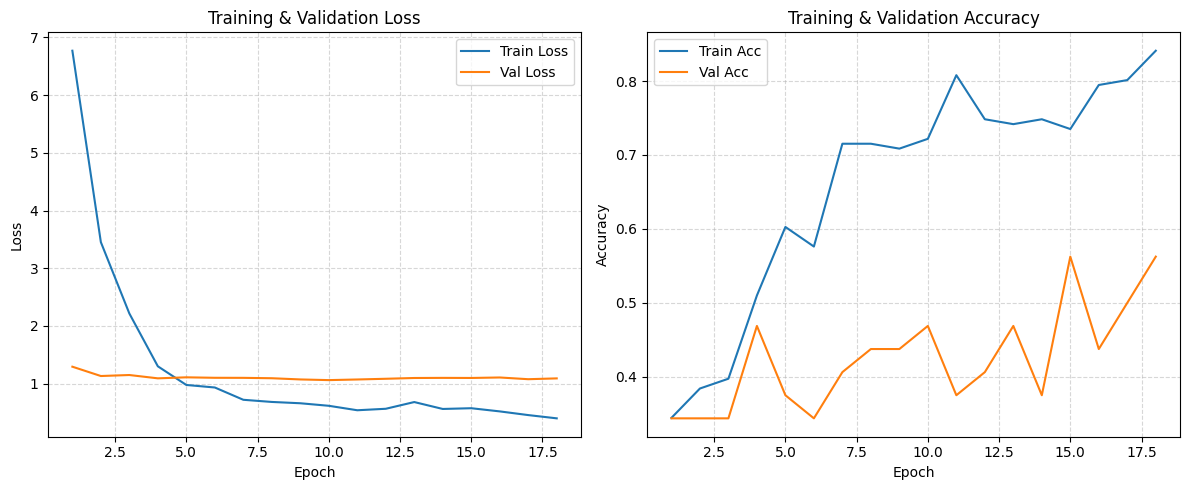

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict.get("loss", [])
val_loss   = history_dict.get("val_loss", [])
train_acc  = history_dict.get("accuracy", [])
val_acc    = history_dict.get("val_accuracy", [])

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# ---- Plot loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# ---- Plot accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


🧩 Cell 10 – Evaluasi di test set

In [17]:
# Cell 10: Evaluasi di test set

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test acc : {test_acc:.4f}")

# Prediksi & laporan klasifikasi
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification report (label 0=Afi, 1=Kinan, 2=Miftah):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Test loss: 1.1869
Test acc : 0.3636
2/2 [==============================] - 0s 2ms/step

Classification report (label 0=Afi, 1=Kinan, 2=Miftah):
              precision    recall  f1-score   support

           0     1.0000    0.1818    0.3077        11
           1     0.1667    0.0909    0.1176        11
           2     0.3600    0.8182    0.5000        11

    accuracy                         0.3636        33
   macro avg     0.5089    0.3636    0.3084        33
weighted avg     0.5089    0.3636    0.3084        33

Confusion matrix:
[[ 2  3  6]
 [ 0  1 10]
 [ 0  2  9]]


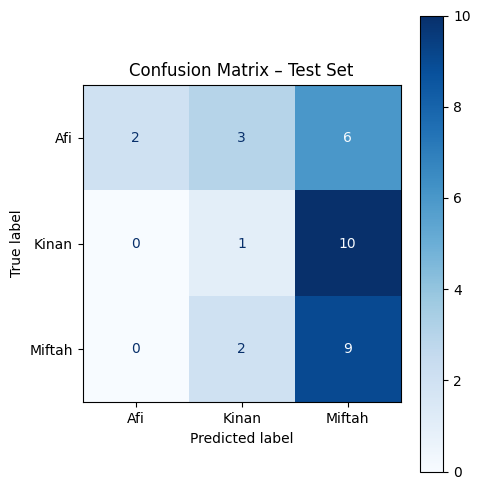

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels_order = [0, 1, 2]
label_names = ["Afi", "Kinan", "Miftah"]

cm = confusion_matrix(y_test, y_pred, labels=labels_order)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix – Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


🧩 Cell 11 – Simpan model final (opsional jika mau override)

In [19]:
final_model_path = "pointnet_spatial_only_final.h5"
model.save(final_model_path)
print("Model final disimpan ke:", final_model_path)


Model final disimpan ke: pointnet_spatial_only_final.h5
